# **LIME**

LIME (Local Interpretable model-agnostic explainations) is a XAI technique that works with black box models and can be used for any machine learning model, thus it is a post-hoc explainer.

Beacause of the fact that a decision function that is computed in a the model often is complex and nonlinear we don't look at the whole decision function but select a single datapoint. For that point we try to find a linear model that can explain all teh points in the neighbourhood well.

That can help us to make good decisions because the LIME-algorithm justifies its prediction by weigthing different input features. A person who has **prior knoledge** can check the weighted features before making the final decision.


## 1. Understanding the Math



*    $x \in \mathbb{R}^{d} $ is the original representation of an instance being explained
*    $x' \in \{0,1\}^{d'} $ is a binary vector for the interpretable representation of $x$
* $g \in G$ where $g$ is a model and $G$ is the class of potentially interpretable models
* $\Omega(g)$ measures the complexity of a model g
* $f: \mathbb{R}^{d} \rightarrow \mathbb{R}$ is the model being explained where $f(x)$ is the probability that x belongs to a certain class
* $\pi_x(z)$ is a proximity measure between an instance $z$ to $x$, to define locality around $x$, thus a high $\pi_x(z)$ shows that the points are nearby
* $\mathcal{L}(f,g,\pi_x)$ (the fidelity function) is a measure of how unfaithful $g$ is in approximating $f$ in the locality defined by $\pi_x$

### Fidelity-Interpretability Trage-off

Now we want to minimize $\mathcal{L}(f,g,\pi_x)$ while having the complexity $\Omega(g)$ low enough to be interpretable for humans. Therefore we need to solve the following equation:

$\xi = argmin_{g \in G} \mathcal{L}(f,g,\pi_x) + \Omega(g)$

### Sampling for Local Exploration

We need to draw samples in the neighborhood of $x'$ in order to understand the local behaviour of the decision function. These samples are weighted by $\pi_x$ and are drawn uniformly.

* $z' \in \{0,1\}^{d'}$ is a perturbed sample
* $f(z)$ determines the label for the explanation of the original representation $z \in \mathbb{R}^{d}$
* $\mathcal{Z}$ is the dataset of perturbed samples and their lables

### Sparse Linear Explanations

Now its time do define the proximity measure and the locally weigthed sqare loss.

* $\pi_x(z) = exp(-D(x,z)^2 / \sigma^2)$ where $D$ is a distance function (e.g. L2 or cosine distance)
* $ \mathcal{L}(f,g,\pi_x) = \sum_{z,z' \in \mathcal{Z}} \pi_x(z)(f(z)-g(z'))^2$


## 2. Algorithm

Required: a classifier $f$, a number of samples $N$, an instance $x$ and it's interpretable version x', a similarity kernel $\pi_x$ and the length of explanation $K$




---


Z <- {}

***for*** $i \in \{1,2,3,...,N\}$ ***do***
  
  >$z'_i \leftarrow sampleAround(x')$

  >$\mathcal{Z} \leftarrow \mathcal{Z} \cup \langle z'_i, f(z_i),\pi_x(z_i) \rangle $

***end for***

$\omega \leftarrow K-Lasso(\mathcal{Z}, K)$ with $z'_i$ as features, $f(z)$ as target

return $\omega$

---

![](https://drive.google.com/uc?export=view&id=1u9WRjRieiqDLaCCT3v2_3K9CTqvd4PHe)

The notebook is based on the LIME library https://github.com/marcotcr/lime 

## 3. LIME classifier in a simple case

The following example shows the functionality of LIME for a very simple case. It predicts the probability of a stroke depending on features of a person like age or hypertension.

Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset/version/1

### Imports and installation

In [1]:
# Needs to be executed once
! pip install lime interpret scikit-image tensorflow==1.15.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Clone dataset
! git clone https://gist.github.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04 'stroke'
! git clone https://github.com/deepfindr/xai-series.git
! git clone https://github.com/mahmouddraz/xai 'xai_workshop'

# Imports
import sys 
import pandas as pd
from sklearn.model_selection import train_test_split
import sys 
sys.path.append(f'/content/xai-series')
import warnings 
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from interpret.blackbox import LimeTabular
from interpret import show
import pickle

fatal: destination path 'stroke' already exists and is not an empty directory.
fatal: destination path 'xai-series' already exists and is not an empty directory.
fatal: destination path 'xai_workshop' already exists and is not an empty directory.


### Loading and exploring the dataset

In [3]:
#Read data
data = pd.read_csv('/content/stroke/healthcare-dataset-stroke-data.csv')

#Print the data
print(f'We have {len(data)} datapoints.')
print("The first datapoints are: ")
print(data.iloc[0:10,:].to_markdown()) 

We have 5110 datapoints.
The first datapoints are: 
|    |    id | gender   |   age |   hypertension |   heart_disease | ever_married   | work_type     | Residence_type   |   avg_glucose_level |   bmi | smoking_status   |   stroke |
|---:|------:|:---------|------:|---------------:|----------------:|:---------------|:--------------|:-----------------|--------------------:|------:|:-----------------|---------:|
|  0 |  9046 | Male     |    67 |              0 |               1 | Yes            | Private       | Urban            |              228.69 |  36.6 | formerly smoked  |        1 |
|  1 | 51676 | Female   |    61 |              0 |               0 | Yes            | Self-employed | Rural            |              202.21 | nan   | never smoked     |        1 |
|  2 | 31112 | Male     |    80 |              0 |               1 | Yes            | Private       | Rural            |              105.92 |  32.5 | never smoked     |        1 |
|  3 | 60182 | Female   |    49 |          

In [4]:
# Load pretrained model and data
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke.pickle', "rb") as f:
  rf = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke_X_train.pickle', "rb") as f:
  X_train = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke_X_test.pickle', "rb") as f:
  X_test = pickle.load(f)
with open('/content/xai_workshop/pretrained_networks/rf_stroke/rf_stroke_y_test.pickle', "rb") as f:
  y_test = pickle.load(f)

In [5]:
#Apply lime
#Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=rf.predict_proba, #	Predicted class probabilities for X
                   data=X_train,                # Training data
                   random_state=1)              # Will be used to generate random numbers

In the next step we train the classifier and generate a table that shows the influence of different parameters on the prediction.

For different data points we can see the prdicted value where 0 means no stroke and 1 means stroke. Additionally we can see the actual value.

In [6]:
#Get local explanations of the test data
num_of_expalainations = 30

lime_local = lime.explain_local(X_test[-num_of_expalainations:], 
                                y_test[-num_of_expalainations:], 
                                name='LIME')
show(lime_local)

## 4. LIME classifier with images

LIME can also be used to find out which parts of an image are used to classify it. Therefore we can choose any class and the pixels that have a positive impact on the classification get highlighted.

### Load the network and tensorflow session

In [7]:
#Imports

# For classification we use the pretrained model by Marco Tulio Correia Ribeiro
! git clone https://github.com/marcotcr/tf-models
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append('/content/tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from nets import inception
from preprocessing import inception_preprocessing
from datasets import imagenet
import os
from skimage.segmentation import mark_boundaries
from lime import lime_image
import time
import PIL.Image as Img 

fatal: destination path 'tf-models' already exists and is not an empty directory.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
tf.global_variables_initializer() 
session = tf.Session()
image_size = inception.inception_v3.default_image_size # 299 x 299
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

# Getting a dict of the classes and human readable names
names = imagenet.create_readable_names_for_imagenet_labels()

2022-06-16 19:50:36.523071: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-16 19:50:36.532522: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200210000 Hz
2022-06-16 19:50:36.533167: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15bd100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-16 19:50:36.533210: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [54]:
%%capture
%%bash  
#download pretrained model 
#CHECKPOINT_DIR=/content/tf-models/slim/pretrained
CHECKPOINT_DIR=/content/cats_and_dogs_model
mkdir ${CHECKPOINT_DIR}
wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvf inception_v3_2016_08_28.tar.gz
mv inception_v3.ckpt ${CHECKPOINT_DIR}
rm inception_v3_2016_08_28.tar.gz

In [10]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '/content/cats_and_dogs_model'

init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)

def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})



Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from /content/cats_and_dogs_model/inception_v3.ckpt


Now we want to check why LIME predicts different classes

Original image:


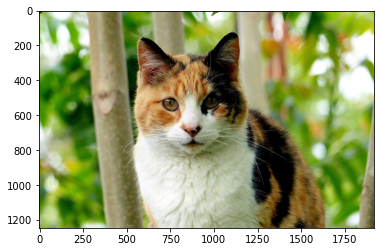

Cropped image:


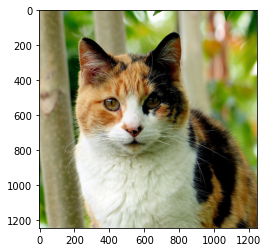

In [25]:
fname = 'cat2.jpg' # Filename of the image to explore
dir = '/content/xai_workshop/images/'

# Cropping the image to have a square image we can feed in the neural network
with Img.open(dir + fname) as im: 
  print("Original image:")
  plt.imshow(im)
  plt.show()

  # Crop depending on the larger dimension
  im_arr = np.array(im)
  shape = im_arr.shape
  diff = abs(shape[0] - shape[1])
  if shape[0] > shape[1]: # Height larger than width 
    im_arr = im_arr[int(diff/2):-int(diff/2), :, :]
  else:                   # Width larger than height 
    im_arr = im_arr[:, int(diff/2):-int(diff/2), :]
 
  print("Cropped image:")
  plt.imshow(im_arr)
  plt.show()

# Downsize the square image to the right size for the network (299 x 299)
image = inception_preprocessing.preprocess_image(tf.convert_to_tensor(Img.fromarray(im_arr), dtype=tf.uint8), image_size, image_size, is_training=False)
image = session.run([[image]])[0]

In [33]:
predictions = predict_fn(image)
print("The top six predicted classes for the image are:")
for ind, x in enumerate(reversed(predictions.argsort()[0][-6:])):
    print (f"{ind+1} {names[x]} (#{x}) {predictions[0,x]*100:.1f}%")

The top six predicted classes for the image are:
1 tiger cat (#283) 59.3%
2 tabby, tabby cat (#282) 24.8%
3 Egyptian cat (#286) 9.5%
4 shower curtain (#795) 1.5%
5 window screen (#905) 0.6%
6 plastic bag (#729) 0.2%


In [34]:
explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image[0].astype('double'), predict_fn, top_labels=6, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Inspecting the image

At this point we want to find out how the neural network chose the top class

In [47]:
# Determine the top class we want to inspect
class_to_inspect = 3
n = predictions.argsort()[0][-class_to_inspect]

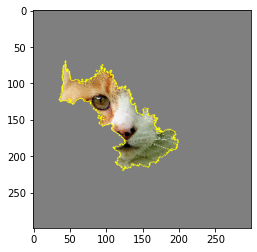

In [48]:
# Plot the boundary of the top superpixels that suggest the given class
temp, mask = explanation.get_image_and_mask(n, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

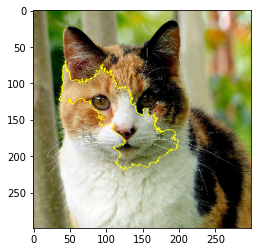

In [49]:
# Same as before but with the rest of the image
temp, mask = explanation.get_image_and_mask(n, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

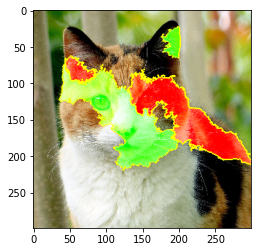

In [50]:
# Mark the top superpixels that are pro the given class (green) and contra the given class (red)
temp, mask = explanation.get_image_and_mask(n, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

## 5. Exercise

Answer the following questions:

1. Find a patient in the test data with a stroke. What are the top features that cause a stroke?
2. How often is the #1 top prediction of the network correct for the six images in the xai_workshop/image folder? How often is one of the top predictions right?
2. What body parts of the cats and dogs are most likely to classify it correctly?